In [21]:
import csv
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

In [3]:
batch_size = 500000
split = 0.7

In [4]:
data = pd.read_csv('train_clean.csv')

In [5]:
data['batch'] = np.ceil((data['time'] * 10000) / batch_size)

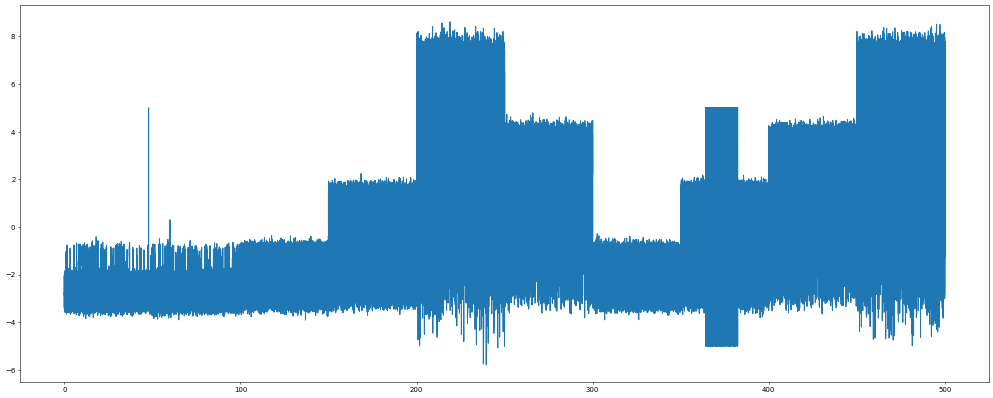

In [6]:
fig = plt.figure(figsize = (25, 10), dpi = 50, facecolor ='w', edgecolor ='k')
plt.plot(data['time'], data['signal'])

In [7]:
# Create the Scaler object
scaler = StandardScaler()

# Fit your data on the scaler object
data['signal'] = scaler.fit_transform(data[['signal']])

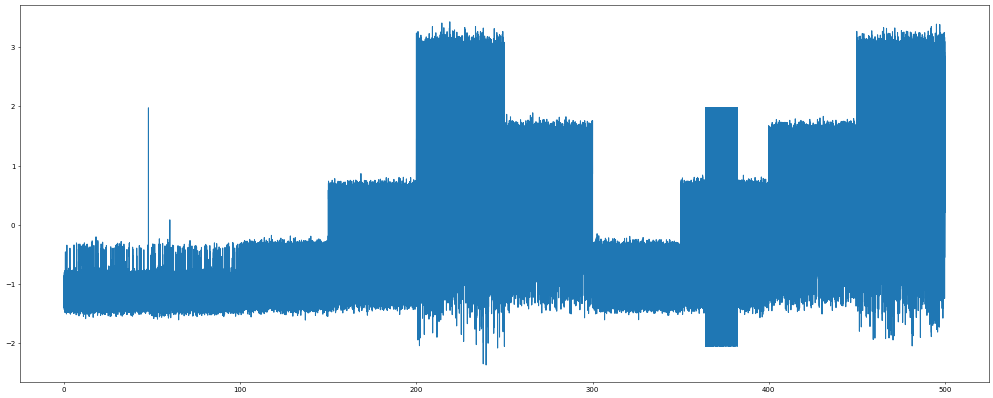

In [8]:
fig = plt.figure(figsize = (25, 10), dpi = 50, facecolor ='w', edgecolor ='k')
plt.plot(data['time'], data['signal'])

In [9]:
labels = np.array(data['open_channels'])

feature_cols = ['signal']
features= data[feature_cols]

feature_list = list(data.columns)
features = np.array(features)

In [10]:
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [11]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (3750000, 1)
Training Labels Shape: (3750000,)
Testing Features Shape: (1250000, 1)
Testing Labels Shape: (1250000,)


In [12]:
model = OneVsRestClassifier(XGBClassifier())

In [13]:
model.fit(train_features, train_labels)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            

In [14]:
# Predicting the Test set results
predictions = model.predict(test_features)

In [15]:
# Making the Confusion Matrix
pd.crosstab(test_labels, predictions, rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9,10
Actual,,,,,,,,,,,
0,307698,1990,52,9,1,2,0,0,1,0,0
1,2383,241912,2242,122,27,10,7,13,8,0,0
2,485,2516,132376,2864,121,32,39,57,80,0,0
3,490,1558,2650,158905,538,40,3175,75,94,0,0
4,1,1497,5787,1264,82177,5,5473,4620,0,0,0
5,0,3,4019,18271,327,26305,400,16149,3805,0,0
6,0,0,0,7777,29394,23,8202,1712,0,0,0
7,0,0,0,3,7611,20465,13,34325,3528,0,0
8,0,0,0,1,2,4910,0,258,53159,3116,0


In [18]:
accuracy_score(test_labels, predictions)

0.8661688

In [22]:
f1_score(test_labels, predictions, average='macro')

0.7614850033453727

In [23]:
sub_data = pd.read_csv('test_clean.csv')
sub_data['signal'] = scaler.fit_transform(sub_data[['signal']])

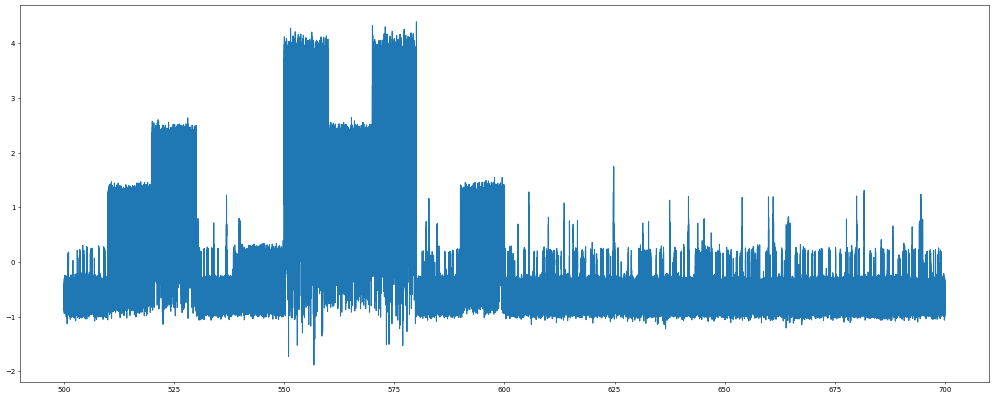

In [24]:
fig = plt.figure(figsize = (25, 10), dpi = 50, facecolor ='w', edgecolor ='k')
plt.plot(sub_data['time'], sub_data['signal'])

In [25]:
sub_features = sub_data[feature_cols]
sub_features = np.array(sub_features)

In [26]:
sub_predictions = model.predict(sub_features)

In [27]:
sub_data['open_channels'] = sub_predictions

In [28]:
sub_data.sample(n=10, random_state=10)

,time,signal,open_channels
690084,569.0085,1.715494,8
333871,533.3872,-0.410850,1
162719,516.2720,0.895352,4
1571186,657.1187,-0.624622,1
528149,552.8150,2.505896,9
505510,550.5511,2.310872,9
910611,591.0612,0.466067,3
740722,574.0723,1.433582,5
1615440,661.5441,-0.647744,1
687279,568.7280,1.527295,8


In [29]:
out_cols = ['time', 'open_channels']
out_data = sub_data[out_cols]

In [30]:
out_data.to_csv('submission.csv', index=False, float_format='%.4f')